In [1]:
import dgl

In [2]:
dataset = dgl.data.CiteseerGraphDataset()
graph = dataset[0]

  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [3]:
features = graph.ndata['feat']
labels = graph.ndata['label']


In [4]:
train_mask = graph.ndata['train_mask']
test_mask = graph.ndata['test_mask']

In [5]:
train_mask

tensor([ True,  True,  True,  ..., False, False, False])

In [6]:
labels[train_mask]

tensor([3, 1, 5, 5, 3, 1, 3, 0, 3, 5, 2, 4, 2, 1, 2, 3, 2, 4, 4, 0, 1, 5, 5, 3,
        5, 2, 5, 2, 4, 2, 2, 2, 4, 5, 2, 3, 4, 5, 3, 3, 2, 1, 2, 1, 5, 1, 1, 4,
        2, 3, 3, 2, 5, 2, 5, 1, 4, 1, 4, 2, 2, 3, 4, 5, 5, 1, 3, 3, 4, 2, 4, 1,
        1, 5, 0, 2, 0, 3, 5, 2, 4, 1, 1, 4, 4, 0, 4, 4, 5, 3, 5, 5, 4, 5, 3, 1,
        4, 4, 3, 1, 3, 0, 1, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [7]:
graph = dgl.remove_self_loop(graph)
graph = dgl.add_self_loop(graph)

In [8]:
feat_in = features.shape[-1]
num_class = dataset.num_classes

In [9]:
from dgl.nn import GraphConv
import torch.nn as nn
import torch.nn.functional as func

Explanation of GraphConv
GraphConv(
    in_feats,
    out_feats,
    norm='both',
    weight=True,
    bias=True,
    activation=None,
    allow_zero_in_degree=False,
)

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = GraphConv(feat_in, 64)
        self.layer2 = GraphConv(64, num_class)
        self.layer2 = GraphConv(64, num_class)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, g, features):
        h1 = func.relu(self.layer1(g, features))
        h1 = self.dropout(h1)
        h2 = self.layer2(g, h1)
        return h2
    

net = Net()

In [11]:
import torch
import matplotlib.pyplot as plt

In [12]:
def evaluate(model, g, features, labels, mask):
    model.eval()
    with torch.no_grad():
        pred = model(g, features)
        pred = pred[mask]
        labels = labels[mask]
        
        _, indices = torch.max(pred, dim=1)
        correct = torch.sum(indices == labels)
        
        return correct.item()*1.0/len(labels)

In [13]:
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-2, weight_decay = 5e-4, eps = 1e-8, amsgrad = True)
lost_list = []
acc_list = []
all_pred = []

for each in range(200):
    net.train()
    pred = net(graph, features)
    logp = func.log_softmax(pred, 1)
    all_pred.append(logp)
    
    loss = func.cross_entropy(logp[train_mask], labels[train_mask])
    optimizer.zero_grad() 
    loss.backward()
    optimizer.step()
    
    acc = evaluate(net, graph, features, labels, test_mask)
    acc_list.append(acc)
    lost_list.append(loss.item())

Text(0, 0.5, 'Acc')

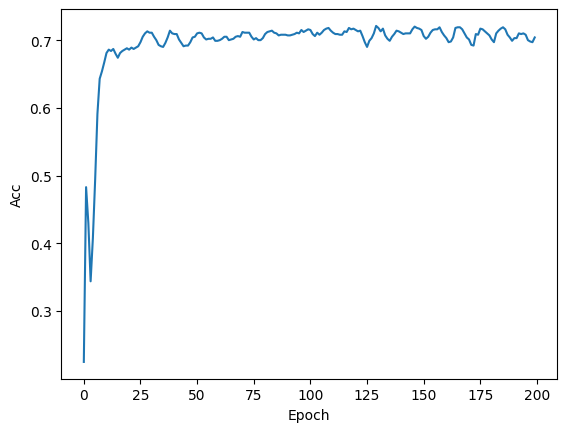

In [14]:
plt.plot(acc_list)
plt.xlabel('Epoch')
plt.ylabel('Acc')


In [15]:
max(acc_list)

0.721

In [16]:
acc_list[-1]

0.704